# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

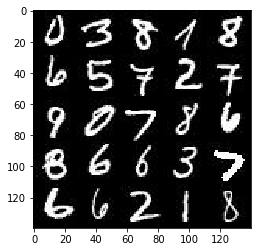

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

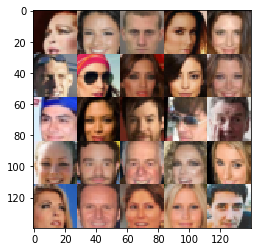

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real')
    
    inputs_z = tf.placeholder(tf.float32, 
                              (None, z_dim), 
                              name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    stddev_def = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        hl1 = tf.layers.conv2d(images, 64, 3, strides=1, padding='valid',
                               kernel_initializer = tf.random_normal_initializer(stddev=stddev_def))
        
        hl1 = tf.maximum(alpha*hl1, hl1)
        
        # Hidden Layer 2
        hl2 = tf.layers.conv2d(hl1, 128, 5, strides=2, padding='same',
                              kernel_initializer = tf.random_normal_initializer(stddev=stddev_def))
        hl2 = tf.layers.batch_normalization(hl2, training=True)
        hl2 = tf.maximum(alpha*hl2, hl2)
        
        # Hidden Layer 3
        hl3 = tf.layers.conv2d(hl2, 256, 5, strides=2, padding='same', 
                             kernel_initializer = tf.random_normal_initializer(stddev=stddev_def))
        hl3 = tf.layers.batch_normalization(hl3, training=True)
        hl3 = tf.maximum(alpha*hl3, hl3)

        
         # Hidden Layer 3
        hl4 = tf.layers.conv2d(hl3, 512, 5, strides=1, padding='same', 
                             kernel_initializer = tf.random_normal_initializer(stddev=stddev_def))
        hl4 = tf.layers.batch_normalization(hl3, training=True)
        hl4 = tf.maximum(alpha*hl3, hl3)
        
        # Flatten
        flat   = tf.contrib.layers.flatten(hl3,  (-1, 7*7*512))
        # Logit
        logits = tf.layers.dense(flat, 1)
        #discriminator output sigmoid
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        L1 = tf.layers.dense(z, 7*7*512)
        
        # Convolution
        L1 = tf.reshape(L1, (-1, 7, 7, 512))
        L1 = tf.layers.batch_normalization(L1, training=is_train)
        L1 = tf.maximum(alpha * L1, L1)
        
        
        L2 = tf.layers.conv2d_transpose(L1, 256, 5, strides=2, padding='same')
        L2 = tf.layers.batch_normalization(L2, training=is_train)
        L2 = tf.maximum(alpha * L2, L2)
        
        
        L3 = tf.layers.conv2d_transpose(L2, 128, 5, strides=2, padding='same')
        L3 = tf.layers.batch_normalization(L3, training=is_train)
        L3 = tf.maximum(alpha * L3, L3)
    
        L4 = tf.layers.conv2d_transpose(L3, 64, 3, strides=1, padding='same')
        L4 = tf.layers.batch_normalization(L4, training=is_train)
        L4 = tf.maximum(alpha * L4, L4)
        
        logits = tf.layers.conv2d_transpose(L4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)

        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

        # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Set image dimensions
    _, image_width, image_height, image_channels = data_shape
    # Set model inputs
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    # Set model loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # Set model optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps    = 0    
    print_at = 50
    show_at  = 200
    
    saver    = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2.0
                
                # Sample random noise for G
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: sample_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: sample_z, learn_rate: learning_rate}) 
            
                                
                if steps % print_at == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Step {}, Epoch {}/{}...".format(steps, epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_at == 0:
                    show_generator_output(sess, 64, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 50, Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 1.9279
Step 100, Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.9835
Step 150, Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 1.1909
Step 200, Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.4883


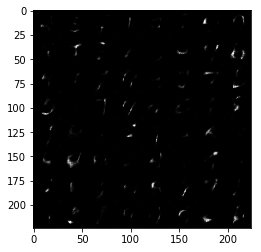

Step 250, Epoch 1/2... Discriminator Loss: 1.7695... Generator Loss: 1.8592
Step 300, Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.6543
Step 350, Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 1.0102
Step 400, Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 0.6190


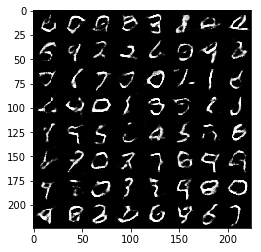

Step 450, Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.9485
Step 500, Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 1.5245
Step 550, Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 0.5290
Step 600, Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.7198


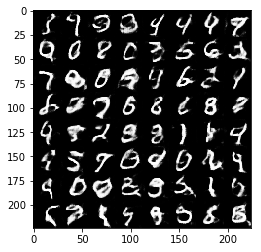

Step 650, Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 1.3576
Step 700, Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.7309
Step 750, Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.8213
Step 800, Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.8655


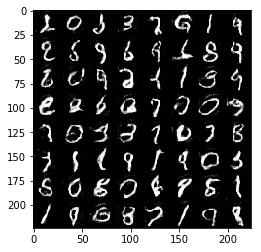

Step 850, Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 1.2731
Step 900, Epoch 1/2... Discriminator Loss: 1.9949... Generator Loss: 3.0012
Step 950, Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 0.5179
Step 1000, Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.8920


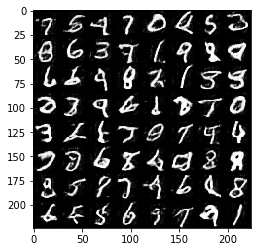

Step 1050, Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.6816
Step 1100, Epoch 2/2... Discriminator Loss: 1.5687... Generator Loss: 0.4486
Step 1150, Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.8875
Step 1200, Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.6832


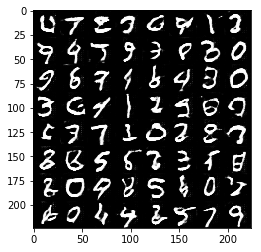

Step 1250, Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.6197
Step 1300, Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 0.9530
Step 1350, Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.5583
Step 1400, Epoch 2/2... Discriminator Loss: 1.8507... Generator Loss: 2.9551


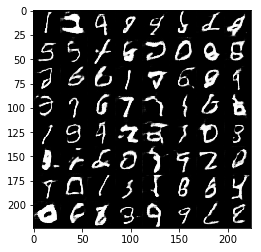

Step 1450, Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 1.2859
Step 1500, Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.7175
Step 1550, Epoch 2/2... Discriminator Loss: 2.1443... Generator Loss: 0.2492
Step 1600, Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 1.3593


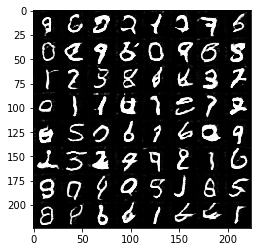

Step 1650, Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.6040
Step 1700, Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.6544
Step 1750, Epoch 2/2... Discriminator Loss: 1.1456... Generator Loss: 1.2311
Step 1800, Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.9226


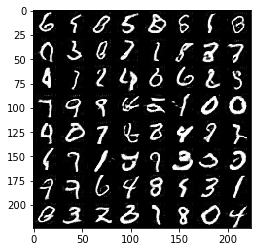

Step 1850, Epoch 2/2... Discriminator Loss: 1.7073... Generator Loss: 0.3473


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 50, Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 4.3281
Step 100, Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.9963
Step 150, Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.1657
Step 200, Epoch 1/1... Discriminator Loss: 1.6752... Generator Loss: 2.3964


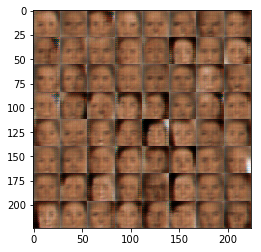

Step 250, Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.0763
Step 300, Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5239
Step 350, Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.6932
Step 400, Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.3852


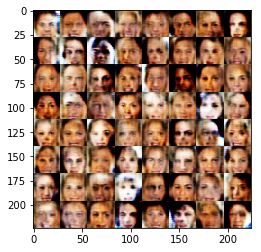

Step 450, Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.7772
Step 500, Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.3641
Step 550, Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 2.3801
Step 600, Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.8855


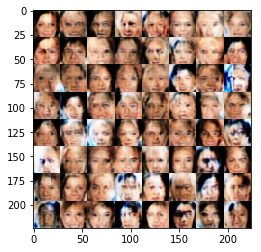

Step 650, Epoch 1/1... Discriminator Loss: 1.9742... Generator Loss: 1.7431
Step 700, Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.8461
Step 750, Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9219
Step 800, Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8792


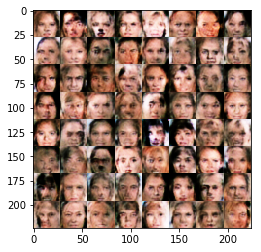

Step 850, Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.9584
Step 900, Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 1.0913
Step 950, Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.5379
Step 1000, Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.5227


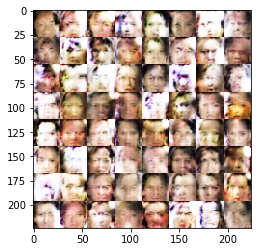

Step 1050, Epoch 1/1... Discriminator Loss: 1.9103... Generator Loss: 0.2689
Step 1100, Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5881
Step 1150, Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8317
Step 1200, Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7258


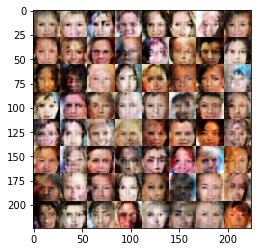

Step 1250, Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 1.1082
Step 1300, Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 1.6945
Step 1350, Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5679
Step 1400, Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6890


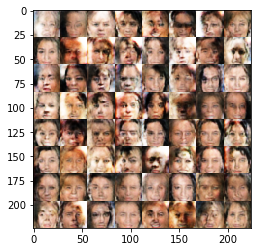

Step 1450, Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.0245
Step 1500, Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.9926
Step 1550, Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 1.2805
Step 1600, Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.3997


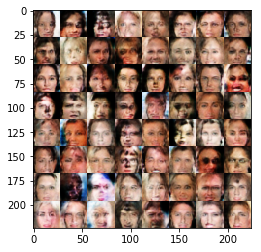

Step 1650, Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8619
Step 1700, Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6247
Step 1750, Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6064
Step 1800, Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.9201


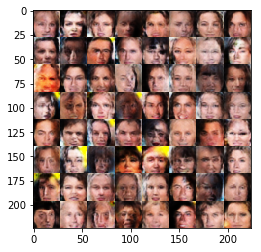

Step 1850, Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6949
Step 1900, Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.4487
Step 1950, Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5473
Step 2000, Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.0169


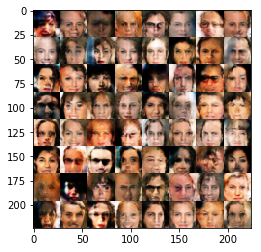

Step 2050, Epoch 1/1... Discriminator Loss: 2.0086... Generator Loss: 2.3483
Step 2100, Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.9716
Step 2150, Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7430
Step 2200, Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.0038


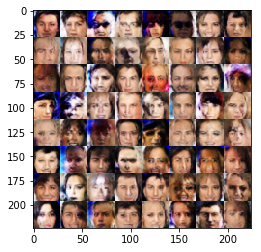

Step 2250, Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.6282
Step 2300, Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7310
Step 2350, Epoch 1/1... Discriminator Loss: 1.7449... Generator Loss: 1.8338
Step 2400, Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6293


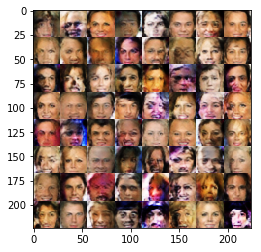

Step 2450, Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.9103
Step 2500, Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.9509
Step 2550, Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.7719
Step 2600, Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 1.3546


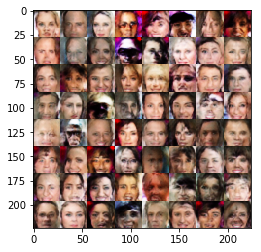

Step 2650, Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.2388
Step 2700, Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.5677
Step 2750, Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.5417
Step 2800, Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5801


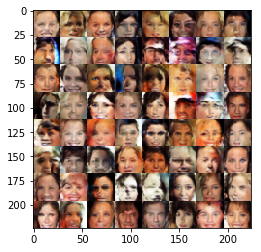

Step 2850, Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 1.1501
Step 2900, Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.5033
Step 2950, Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.4756
Step 3000, Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.4987


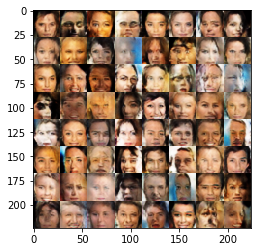

Step 3050, Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7214
Step 3100, Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6131
Step 3150, Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.4802


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.